# Covid-19: Daily New Cases in Argentina - Recursive SARIMA on IHS Transformed

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialization" data-toc-modified-id="Initialization-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialization</a></span></li><li><span><a href="#Analysis-and-Transformation" data-toc-modified-id="Analysis-and-Transformation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Analysis and Transformation</a></span></li><li><span><a href="#Hyper-Parameters-Search" data-toc-modified-id="Hyper-Parameters-Search-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Hyper Parameters Search</a></span></li><li><span><a href="#Training-and-Validation" data-toc-modified-id="Training-and-Validation-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Training and Validation</a></span><ul class="toc-item"><li><span><a href="#Distributions-of-Validation-Errors" data-toc-modified-id="Distributions-of-Validation-Errors-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distributions of Validation Errors</a></span></li><li><span><a href="#Visualization-of-Validation-Predictions" data-toc-modified-id="Visualization-of-Validation-Predictions-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualization of Validation Predictions</a></span></li></ul></li><li><span><a href="#Test-Predictions" data-toc-modified-id="Test-Predictions-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Test Predictions</a></span></li></ul></div>

## Initialization

In [37]:
# !pip install --use-feature=in-tree-build psutil requests pmdarima nb_black

<IPython.core.display.Javascript object>

In [38]:
# !pip install --use-feature=in-tree-build ../pytorch-fit/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/pytorch-fit

<IPython.core.display.Javascript object>

In [39]:
# !pip install --use-feature=in-tree-build ../timeseries/
# !pip install --use-feature=in-tree-build git+https://github.com/krzpiesiewicz/timeseries

<IPython.core.display.Javascript object>

In [40]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2
%aimport timeseries

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>

In [41]:
import os
import sys
import time
import IPython.display
from pprint import pprint
import matplotlib.colors as mcolors
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import acf, pacf

import timeseries as tss
from timeseries.plotting import plot_ts, plot_hist, plot_acf, plot_pacf
from timeseries.transform import IHSTransformer, get_smoothed

from utils.timeseries_data import Covid19Data
from utils.results import Results
from utils.plotting import (
    plot_model_test_prediction,
    plot_ground_truth,
    plot_hist_model_scores,
)
from scorings import get_comparison_scorings
from average_scoring import average_scores
from hyper_params import (
    make_grid,
    grid_search_hyper_params,
    print_hyper_scores,
    sorted_scores,
)
from models.sarima import SarimaModel, sarima_model_version, sarima_model_version_str

<IPython.core.display.Javascript object>

In [42]:
import nb_black

from utils.notebook_init import notebook_init

notebook_init()

<IPython.core.display.Javascript object>

In [43]:
scorings = get_comparison_scorings()

ts_data = Covid19Data()
data_type = ts_data.data_type
data_name = ts_data.data_name

val_results = Results(data_type, data_name, "val")
test_results = Results(data_type, data_name, "test")

ts = ts_data.ts
train_intv = ts_data.train_interval
val_intv = ts_data.val_interval
test_intv = ts_data.test_interval
train_val_intv = tss.Interval(ts, train_intv.begin, val_intv.end)
pred_steps = ts_data.pred_steps
pred_jump = ts_data.pred_jump

<IPython.core.display.Javascript object>

## Analysis and Transformation

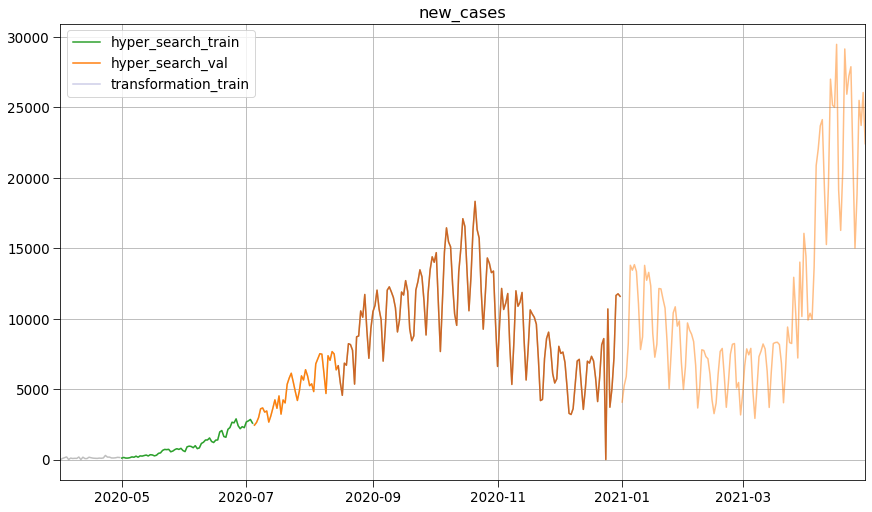

<IPython.core.display.Javascript object>

In [99]:
sarima_train_intv = tss.Interval(ts, datetime(2020, 5, 1), train_intv.end)
sarima_train_val_intv = tss.Interval(ts, train_intv.begin, val_intv.end)
hyper_search_val_datetime = datetime(2020, 7, 5)
hyper_search_train_intv = tss.Interval(
    ts, sarima_train_intv.begin, hyper_search_val_datetime
)
hyper_search_val_intv = tss.Interval(ts, hyper_search_val_datetime, val_intv.begin)
transformation_train_intv = tss.Interval(
    ts, datetime(2020, 8, 15), datetime(2021, 1, 1)
)

fig = plot_ts(
    train_val_intv.view(end=sarima_train_intv.begin), color="tab:grey", alpha=0.5
)
plot_ts(sarima_train_intv.view(), color="tab:green", alpha=0.2, fig=fig)
plot_ts(val_intv.view(ts), color="tab:orange", alpha=0.5, fig=fig)
plot_ts(
    hyper_search_train_intv.view(),
    color="tab:green",
    name="hyper_search_train",
    fig=fig,
)
plot_ts(
    hyper_search_val_intv.view(), color="tab:orange", name="hyper_search_val", fig=fig
)
plot_ts(
    transformation_train_intv.view(),
    color="darkblue",
    name="transformation_train",
    alpha=0.2,
    fig=fig,
)
display(fig)

Order of differencing: 1


train skewness of ordinary normalized differences: 0.19476842596173197
val skewness of ordinary normalized differences: 0.03586865063095212


Order of differencing: 1
MLE of IHS lambda: 2.612500e-04


train skewness of normalized differences with IHS transformation: -0.03325554826546039
val skewness of normalized differences with IHS transformation: 0.08097850287736505


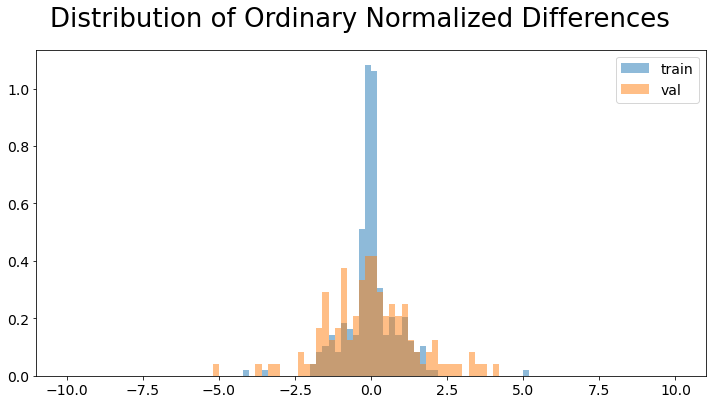

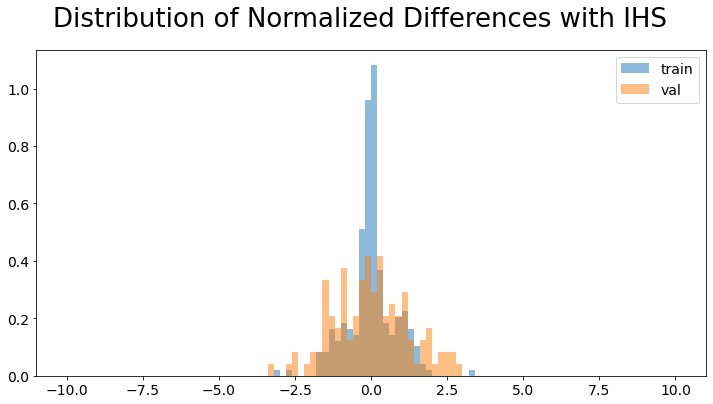

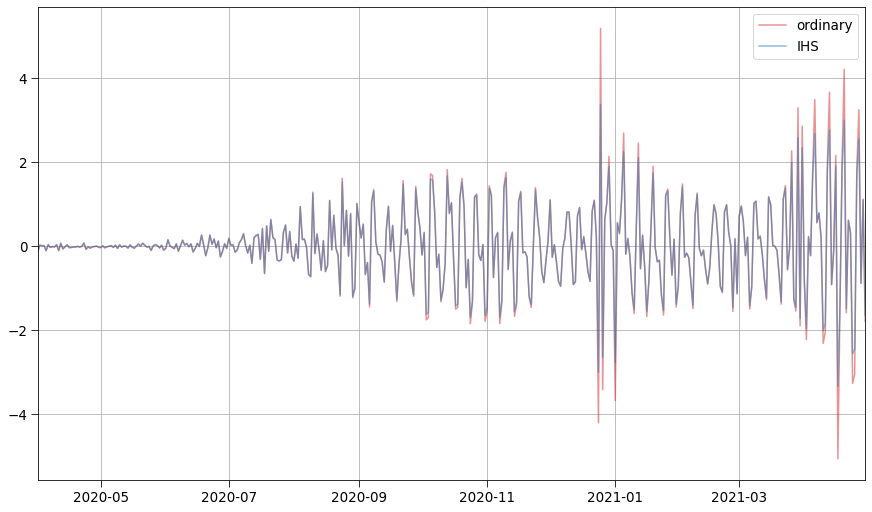

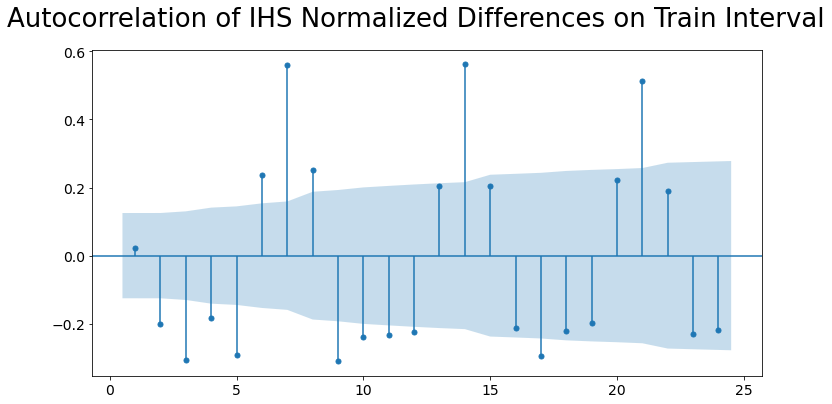

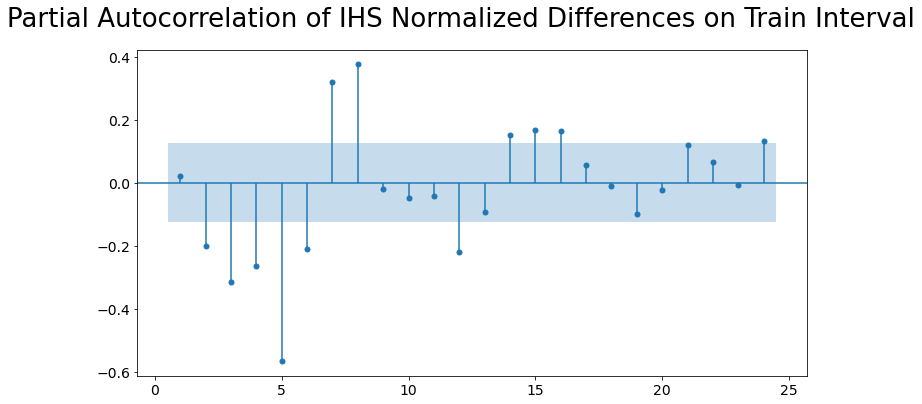

<IPython.core.display.Javascript object>

In [100]:
ordinary_transformation_train_intv = tss.Interval(
    ts, datetime(2020, 7, 1), train_intv.end
)
ordinary_trans = IHSTransformer(
    ordinary_transformation_train_intv.view(ts), lmb=None, verbose=True
)
ordinary_trans_ts = ordinary_trans.transform(ts)
print(
    f"train skewness of ordinary normalized differences: {sarima_train_intv.view(ordinary_trans_ts).skew()}"
)
print(
    f"val skewness of ordinary normalized differences: {val_intv.view(ordinary_trans_ts).skew()}"
)
time.sleep(1)

trans = IHSTransformer(transformation_train_intv.view(ts), verbose=True)
trans_ts = trans.transform(ts)
print(
    f"train skewness of normalized differences with IHS transformation: {sarima_train_intv.view(trans_ts).skew()}"
)
print(
    f"val skewness of normalized differences with IHS transformation: {val_intv.view(trans_ts).skew()}"
)

fig = plot_hist(
    sarima_train_intv.view(ordinary_trans_ts),
    bins=100,
    range=(-10, 10),
    density=True,
    name="train",
)
display(
    plot_hist(
        val_intv.view(ordinary_trans_ts),
        bins=100,
        range=(-10, 10),
        density=True,
        name="val",
        fig=fig,
        title="Distribution of Ordinary Normalized Differences",
    )
)


fig = plot_hist(
    sarima_train_intv.view(trans_ts),
    bins=100,
    range=(-10, 10),
    density=True,
    name="train",
)
display(
    plot_hist(
        val_intv.view(trans_ts),
        bins=100,
        range=(-10, 10),
        density=True,
        name="val",
        fig=fig,
        title="Distribution of Normalized Differences with IHS",
    )
)

fig = plot_ts(
    train_val_intv.view(ordinary_trans_ts), name="ordinary", color="tab:red", alpha=0.5
)
plot_ts(train_val_intv.view(trans_ts), color="tab:blue", name="IHS", alpha=0.5, fig=fig)
display(fig)

alpha = 0.05
display(
    plot_acf(
        sarima_train_intv.view(trans_ts),
        alpha=alpha,
        zero=False,
        title="Autocorrelation of IHS Normalized Differences on Train Interval",
    )
)
display(
    plot_pacf(
        sarima_train_intv.view(trans_ts),
        alpha=alpha,
        zero=False,
        title="Partial Autocorrelation of IHS Normalized Differences on Train Interval",
    )
)

## Hyper Parameters Search

In [101]:
def sarima_grid_search(scores=None):
    return grid_search_hyper_params(
        SarimaModel,
        grid,
        trans_ts,
        hyper_search_train_intv,
        hyper_search_val_intv,
        model_params=model_params,
        score_params=score_params,
        fit_params=fit_params,
        best=None,
        scores=scores,
    )

<IPython.core.display.Javascript object>

In [102]:
score_params = dict(
    scorings=["mae"],
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=1,
    mute=True,
)

fit_params = dict(scoring="mae")

<IPython.core.display.Javascript object>

In [103]:
%%time
p_range = [0, 1, 2, 3, 4, 5, 6, 7]
d_range= [0]
q_range = [0, 1, 2, 3, 4, 5, 6, 7]
P_range = [0, 1, 2]
D_range = [0]
Q_range = [0, 1, 2]
s_range = [7]
grid = make_grid(p=p_range, d=d_range, q=q_range, P=P_range, D=D_range, Q=Q_range, s=s_range)
grid = [v for v in grid if v["p"] + v["d"] + v["q"] + v["D"] + v["P"] + v["Q"] <= 10]
model_params = dict(maxiter=10)

sarima_grid_search_scores = sarima_grid_search()

138/381 (3h 52min 47s) best: 1372.0 (p=1, d=0, q=4, P=2, D=0, Q=2, s=7)                                       
Terminating: more than 20 fails
381/381 (3h 52min 47s), the best of all: 1372.0 (p=1, d=0, q=4, P=2, D=0, Q=2, s=7)                           


CPU times: user 2h 13min 54s, sys: 1h 44min 12s, total: 3h 58min 7s
Wall time: 3h 52min 48s


<IPython.core.display.Javascript object>

In [104]:
print_hyper_scores(sarima_grid_search_scores[:30], sarima_model_version_str, s=7)

1.   1372.0 – SARIMA(1,0,4)(2,0,2)[7]
2.   1372.1 – SARIMA(0,0,4)(2,0,2)[7]
3.   1376.8 – SARIMA(1,0,4)(2,0,0)[7]
4.   1378.6 – SARIMA(0,0,5)(2,0,2)[7]
5.   1379.5 – SARIMA(0,0,4)(2,0,0)[7]
6.   1382.6 – SARIMA(0,0,3)(2,0,0)[7]
7.   1384.6 – SARIMA(0,0,6)(2,0,2)[7]
8.   1386.1 – SARIMA(0,0,3)(2,0,2)[7]
9.   1397.6 – SARIMA(0,0,3)(2,0,1)[7]
10.  1399.3 – SARIMA(0,0,7)(2,0,0)[7]
11.  1404.6 – SARIMA(0,0,5)(2,0,0)[7]
12.  1405.0 – SARIMA(1,0,3)(2,0,2)[7]
13.  1413.5 – SARIMA(0,0,5)(2,0,1)[7]
14.  1414.5 – SARIMA(0,0,4)(2,0,1)[7]
15.  1415.4 – SARIMA(0,0,2)(2,0,0)[7]
16.  1417.3 – SARIMA(1,0,4)(2,0,1)[7]
17.  1424.9 – SARIMA(0,0,2)(2,0,2)[7]
18.  1428.1 – SARIMA(1,0,3)(2,0,0)[7]
19.  1433.4 – SARIMA(0,0,6)(2,0,0)[7]
20.  1434.4 – SARIMA(0,0,2)(2,0,1)[7]
21.  1435.5 – SARIMA(0,0,6)(2,0,1)[7]
22.  1436.6 – SARIMA(0,0,1)(2,0,0)[7]
23.  1437.2 – SARIMA(1,0,4)(1,0,2)[7]
24.  1439.4 – SARIMA(1,0,1)(2,0,0)[7]
25.  1447.6 – SARIMA(0,0,1)(2,0,2)[7]
26.  1447.8 – SARIMA(1,0,5)(1,0,2)[7]
27.  1448.4 

<IPython.core.display.Javascript object>

## Training and Validation

In [56]:
sarima_grid_search_scores = [(1, dict(p=4, d=0, q=2, P=2, D=0, Q=1, s=7))]

<IPython.core.display.Javascript object>

In [89]:
%%time
models_vals = {sarima_model_version_str(val, suffix=" with IHS"): val for (s, val) in sarima_grid_search_scores[:10]}
models_versions = list(models_vals.keys())
models = {version: SarimaModel(**val) for version, val in models_vals.items()}

val_mean_scores = {}
val_all_scores = {}
val_preds = {}

for i, (model_version, model) in enumerate(models.items()):
    print(f"{i+1}. {model_version}:", file=sys.stderr)
    model.fit(trans_ts, sarima_train_intv, scoring="mae")
    val_mean_scores[model_version], val_all_scores[model_version], val_preds[model_version] = average_scores(
        model,
        trans_ts,
        val_intv,
        scorings=scorings,
        trans=trans,
        original_ts=ts,
        n_steps=pred_steps,
        n_steps_jump=pred_jump,
        return_all_scores=True,
        return_preds=True,
    )
    print(f"\n", file=sys.stderr)
time.sleep(1)


SARIMA(4,0,2)(2,0,1)[7] with IHS:
106/106 – RMSE: 3024.6, MAE: 2534.9, MASE: 1.133, sMAPE: 24.444, elapsed time: 1min 55s (last: 2.0s)      

CPU times: user 1min 31s, sys: 1min 13s, total: 2min 44s
Wall time: 2min 5s


<IPython.core.display.Javascript object>

In [90]:
best_versions = [
    model_version
    for _, model_version in sorted_scores(
        [
            (scores["MAE"], model_version)
            for model_version, scores in val_mean_scores.items()
        ]
    )
]

for i, model_version in enumerate(best_versions[:5]):
    model_name, model_version_str = sarima_model_version(models_vals[model_version])
    val_results.set_model(model_name, model_version_str)
    val_results.add_model_scores(val_mean_scores[model_version])
    val_results.add_model_preds(val_preds[model_version])
    mae = val_mean_scores[model_version]["MAE"]
    print(f"{i+1}. {mae:.1f} – {model_version_str}")

<IPython.core.display.Javascript object>

### Distributions of Validation Errors

In [91]:
scoring_name = "MAE"

fig = None
kwargs = dict(engine="plotly")
for model_version in best_versions[:3]:
    fig = plot_hist_model_scores(
        val_all_scores[model_version],
        scoring_name,
        data_name=data_name,
        model_version=model_version,
        in_label=True,
        fig=fig,
        **kwargs
    )
    kwargs = {}
display(fig)

<IPython.core.display.Javascript object>

### Visualization of Validation Predictions

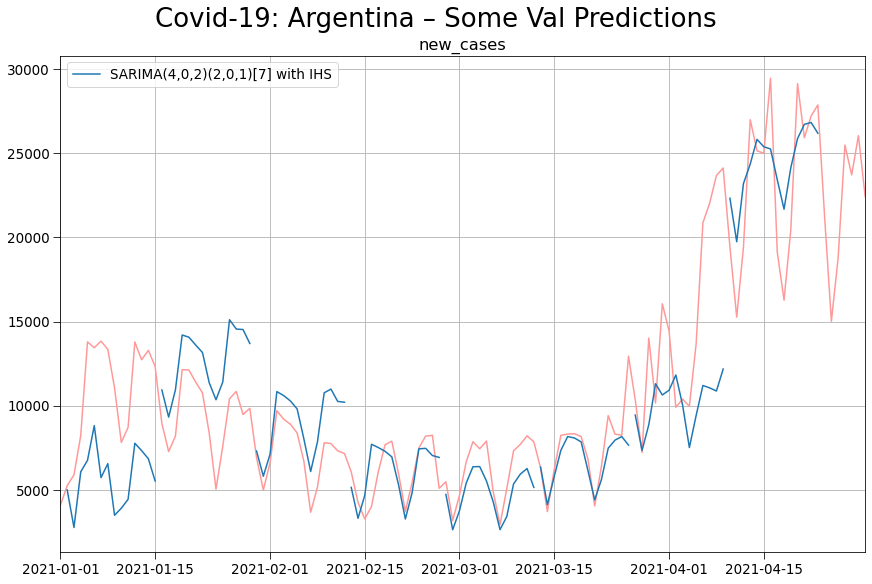

<IPython.core.display.Javascript object>

In [92]:
fig_time_delta = timedelta(days=1)
fig = plot_ground_truth(
    val_intv,
    mode="val",
    data_type=data_type,
    data_name=data_name,
)
for model_version, color in zip(best_versions[:3], mcolors.TABLEAU_COLORS):
    plot_model_test_prediction(
        val_intv,
        fig_time_delta,
        val_preds[model_version],
        model_version=model_version,
        fig=fig,
        color=color,
    )
display(fig)

## Test Predictions

In [62]:
chosen_model_version = "(4,0,2)(2,0,1)[7] with IHS"

<IPython.core.display.Javascript object>

In [63]:
%%time
models[chosen_model_version].update(trans_ts, val_intv)
test_mean_scores, test_all_scores, test_preds = average_scores(
    models[chosen_model_version],
    trans_ts,
    test_intv,
    scorings=scorings,
    trans=trans,
    original_ts=ts,
    n_steps=pred_steps,
    n_steps_jump=pred_jump,
    return_all_scores=True,
    return_preds=True,
)
pprint(test_mean_scores)
test_results.set_model(model_name, chosen_model_version)
test_results.add_model_scores(test_all_scores, test_mean_scores)
test_results.add_model_preds(test_preds)

KeyError: '(4,0,2)(2,0,1)[7] with IHS'

<IPython.core.display.Javascript object>

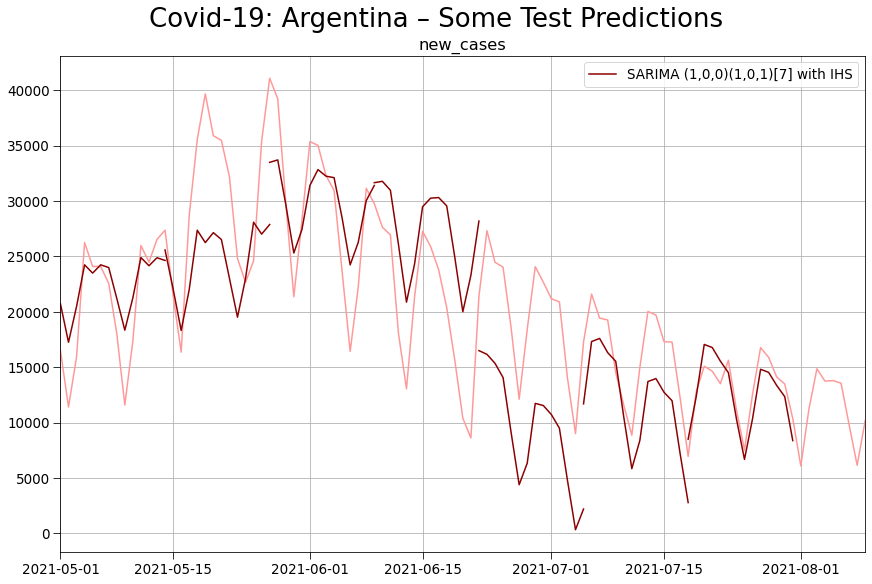

<IPython.core.display.Javascript object>

In [73]:
fig_time_delta = timedelta(days=3)
fig = plot_ground_truth(
    test_intv,
    mode="test",
    data_type=data_type,
    data_name=data_name,
)
display(
    plot_model_test_prediction(
        test_intv,
        fig_time_delta,
        test_preds,
        model_name=model_name,
        model_version=chosen_model_version,
        fig=fig,
    )
)

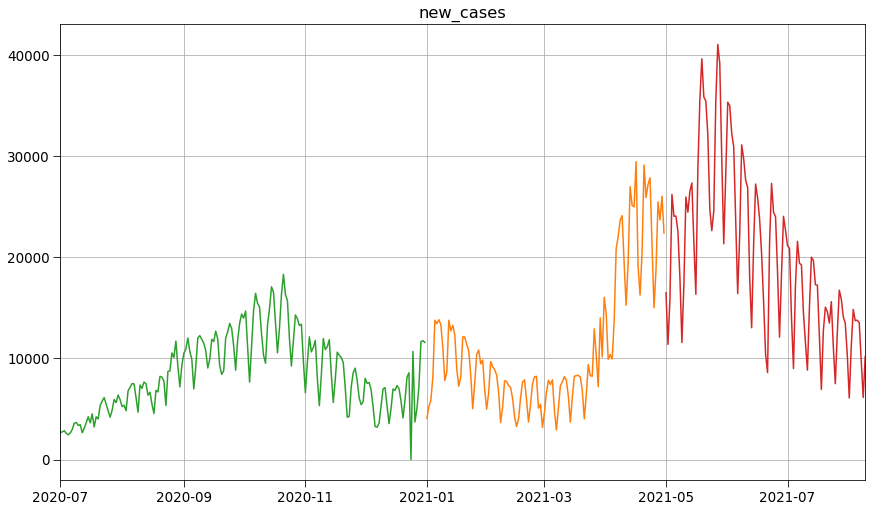

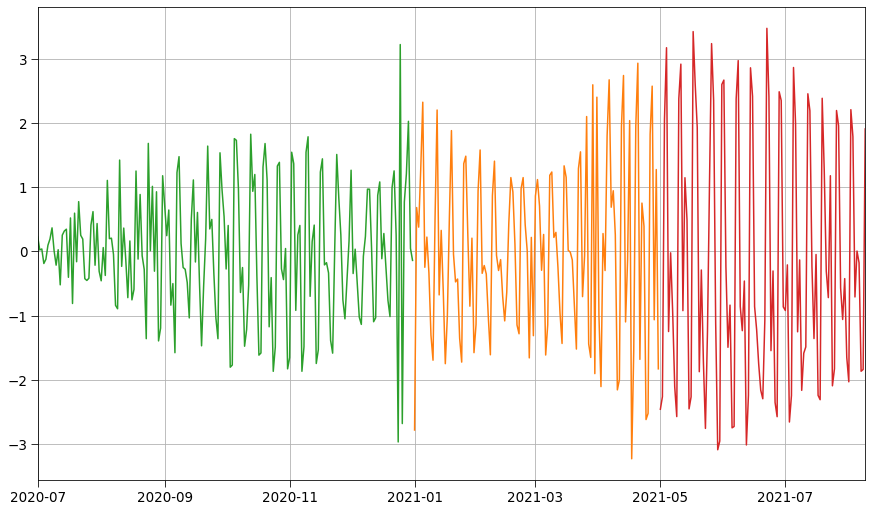

<IPython.core.display.Javascript object>

In [69]:
fig = plot_ts(sarima_train_intv.view(ts), color="tab:green")
plot_ts(val_intv.view(ts), color="tab:orange", fig=fig)
plot_ts(test_intv.view(ts), color="tab:red", fig=fig)
display(fig)
fig = plot_ts(sarima_train_intv.view(trans_ts), color="tab:green")
plot_ts(val_intv.view(trans_ts), color="tab:orange", fig=fig)
plot_ts(test_intv.view(trans_ts), color="tab:red", fig=fig)
display(fig)